In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Lambda
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [2]:
data, labels, _ = utility.load_data()

Dataset split: 70700 train rows
Dataset split: 70700 test rows


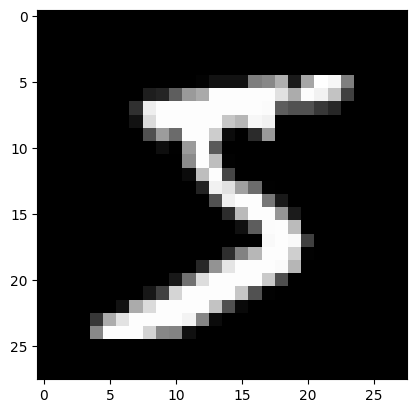

In [3]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [4]:
normal_train_data, anom_train_data, test_data, test_labels, val_data = utility.preprocess_data(data, labels)

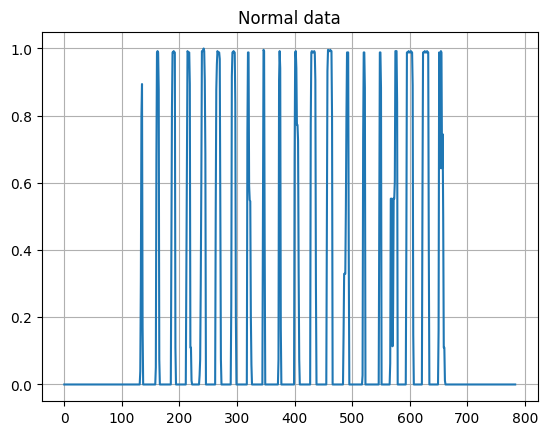

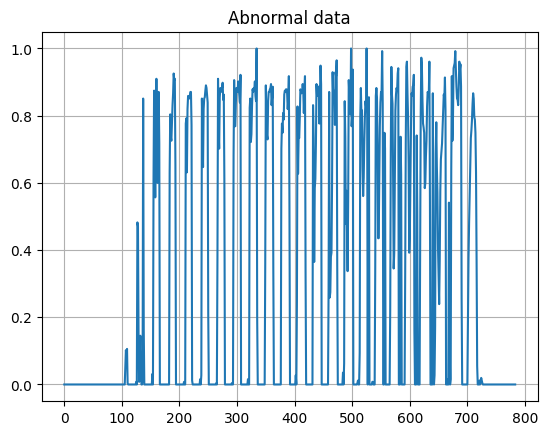

In [5]:
utility.plot_normalized_pixel_data(normal_train_data, anom_train_data)

In [6]:
latent_dim = 2

In [7]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [10]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = x

In [11]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [12]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [13]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [14]:
vae.compile(optimizer='adam')

In [15]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Adding the early stopping callback to the fit method
history = vae.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512, validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/100


83/83 [==============================] - 3s 16ms/step - loss: 0.2333 - val_loss: 0.1572
Epoch 2/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0926 - val_loss: 0.1300
Epoch 3/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0821 - val_loss: 0.1033
Epoch 4/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0776 - val_loss: 0.0870
Epoch 5/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0750 - val_loss: 0.0794
Epoch 6/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0733 - val_loss: 0.0752
Epoch 7/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0722 - val_loss: 0.0735
Epoch 8/100
83/83 [==============================] - 1s 13ms/step - loss: 0.0714 - val_loss: 0.0726
Epoch 9/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0708 - val_loss: 0.0720
Epoch 10/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0704 - val_loss: 0.0713
Epoch 11/10

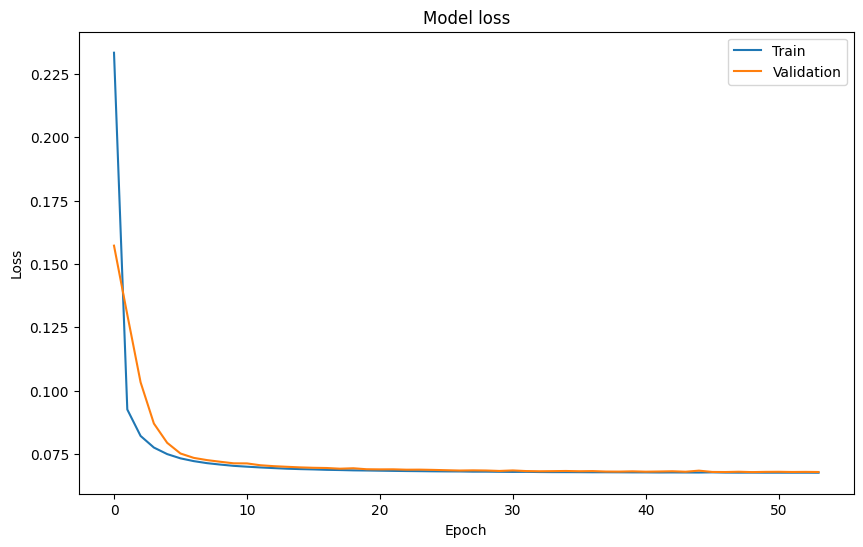

In [16]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1313/1313 [==============================] - 2s 1ms/step


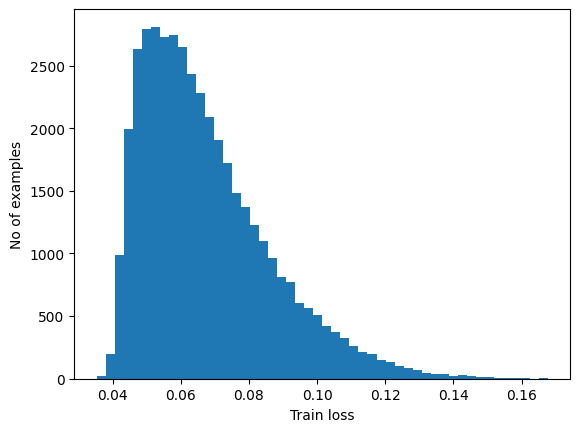

In [17]:
reconstructions = vae.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [18]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
threshold = np.percentile(train_loss, 99)
print("Quantile Threshold ", threshold)

Threshold  0.08633
Quantile Threshold  0.12448833674192392


14/14 [==============================] - 0s 2ms/step


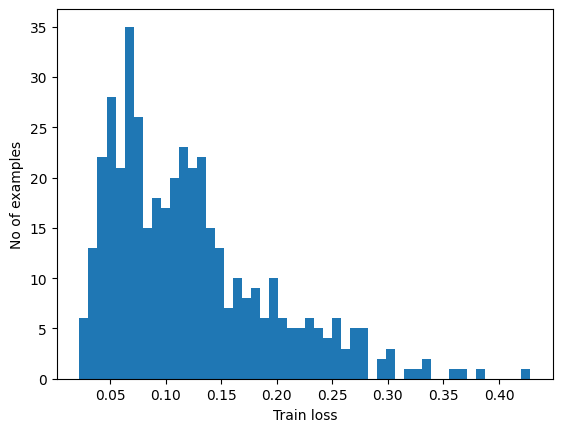

In [19]:
reconstructions = vae.predict(anom_train_data)
train_loss = tf.keras.losses.mse(reconstructions, anom_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [20]:
threshold_anom = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold_anom)

Threshold  0.1951445


In [21]:
preds, loss, proba = utility.predict(vae, test_data, threshold)

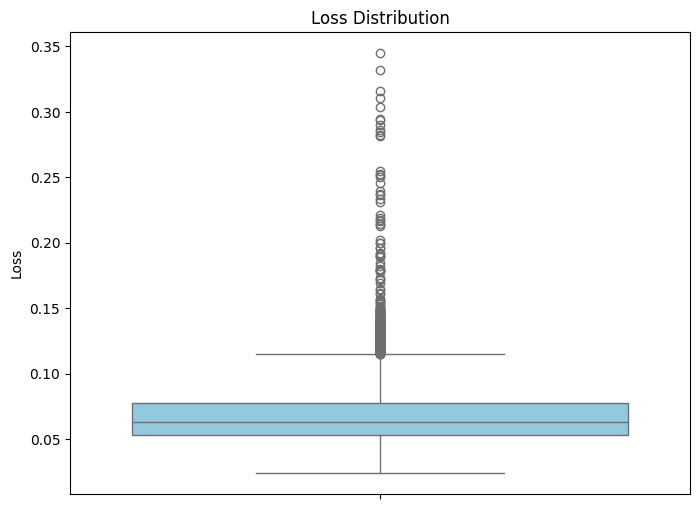

In [22]:
utility.boxplot_plot("Loss", loss)

C:\Users\zippe\AppData\Local\Temp\ipykernel_9512\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


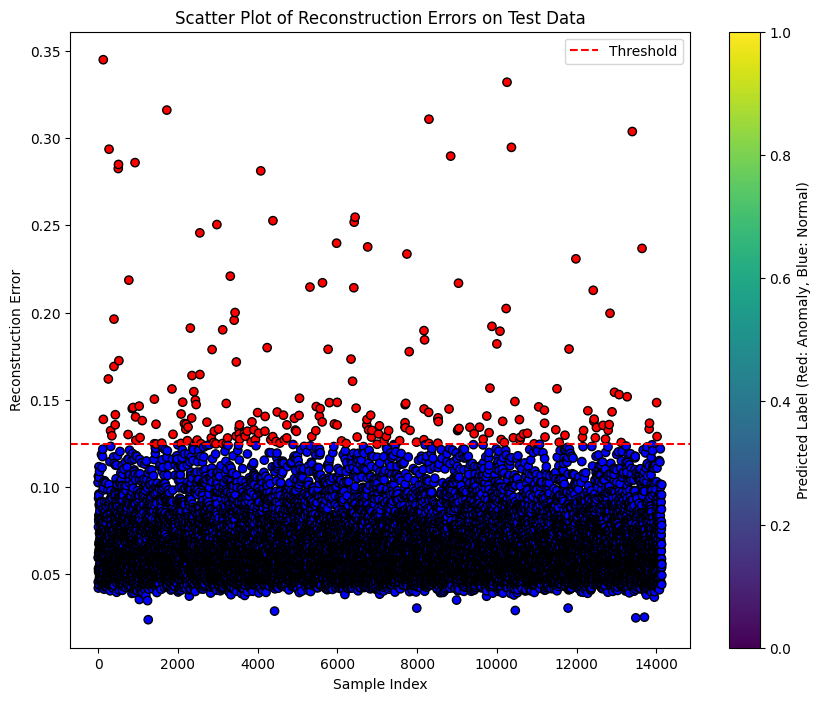

In [23]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [24]:
a, p, r, report, cm = utility.get_metrics(preds, test_labels)

In [25]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9830975954738331
Precision = 0.9941806164235937
Recall = 0.9887110603029436
Report
               precision    recall  f1-score   support

     anomaly       0.29      0.44      0.35       144
      normal       0.99      0.99      0.99     13996

    accuracy                           0.98     14140
   macro avg       0.64      0.71      0.67     14140
weighted avg       0.99      0.98      0.98     14140

Confusion Matrix
[[   63    81]
 [  158 13838]]


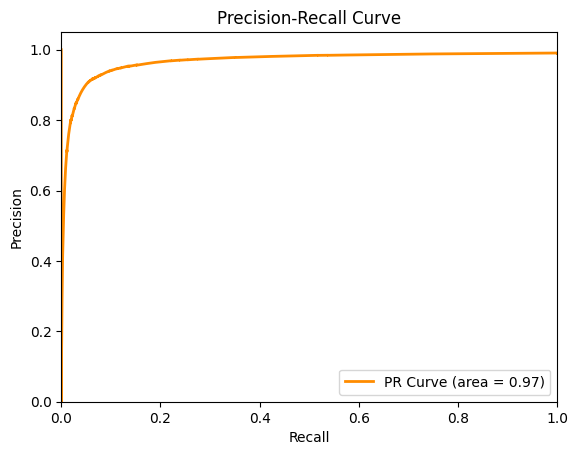

In [26]:
utility.pr_auc_plot(proba, test_labels)

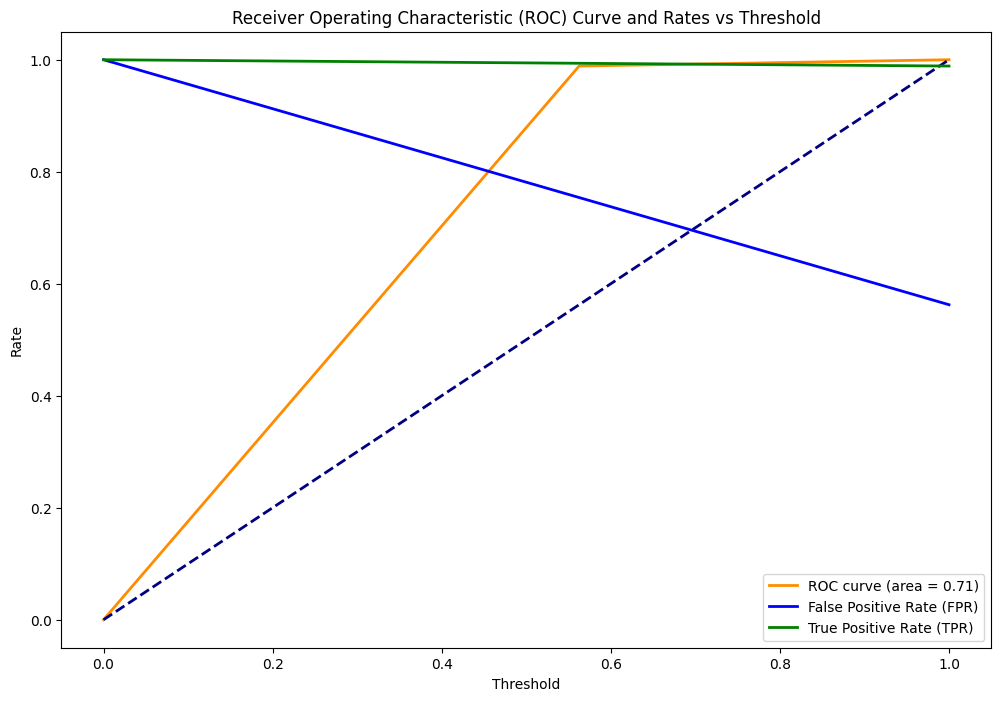

In [27]:
utility.roc_plot(preds, test_labels)

True Negatives: 63
False Positives: 81
False Negatives: 158
True Positives: 13838


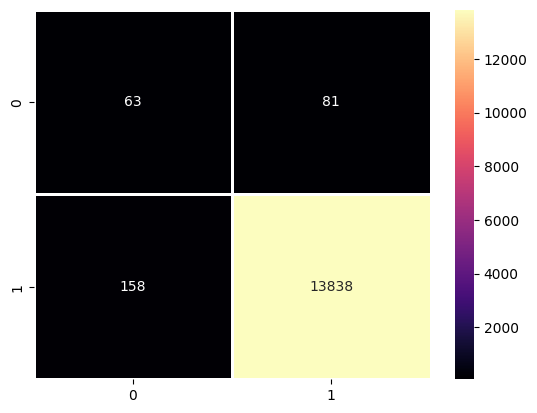

In [28]:
utility.create_heatmap(cm)

In [29]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


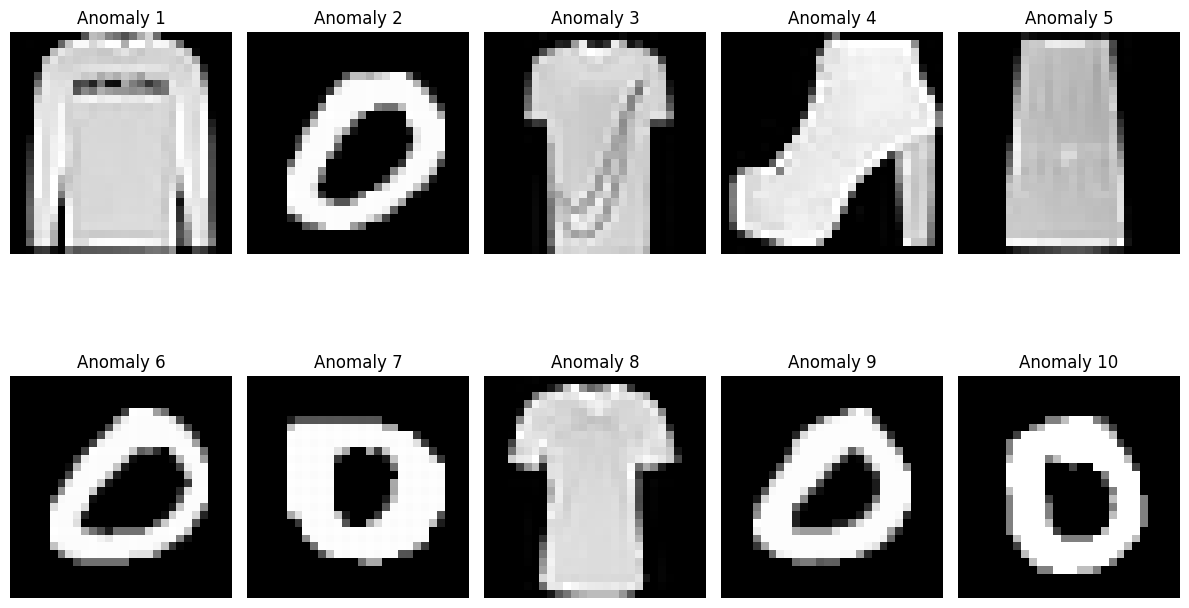

In [30]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)